In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

df = pd.read_csv('adult.csv')
print('數據大小：', df.shape)
print('遺漏值數量：', df.isnull().sum().sum())
df.head(3)

數據大小： (48842, 15)
遺漏值數量： 0


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


In [2]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [3]:
df['income'] = df['income'].map({'<=50K':0, '>50K':1})
features = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
df[features].describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [4]:
# 觀看特徵內容為字串的欄位
df.describe(include=["O"])

,workclass,education,marital-status,occupation,relationship,race,gender,native-country
count,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33906,15784,22379,6172,19716,41762,32650,43832


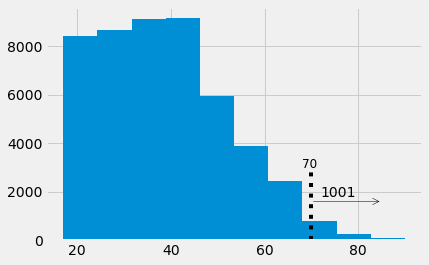

In [5]:
# 探索式分析(EDA)
df['age'].hist()
# 標示高齡人口數
plt.vlines(x=70, ymin=0, ymax=3000, colors='black', linestyles='dotted')
plt.annotate('', xy=(70, 1600), xycoords='data', 
             xytext=(85, 1600), textcoords='data', fontsize=16, 
             arrowprops=dict(arrowstyle='<-', color='black', connectionstyle="arc3"))
plt.text(68, 3000, '70', fontsize=12)
plt.text(72, 1800, '{}'.format(df[df["age"]>=70].shape[0]))
plt.show()

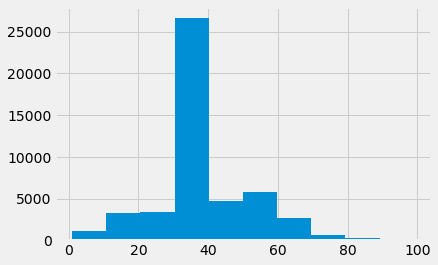

In [6]:
df['hours-per-week'].hist()
plt.show()

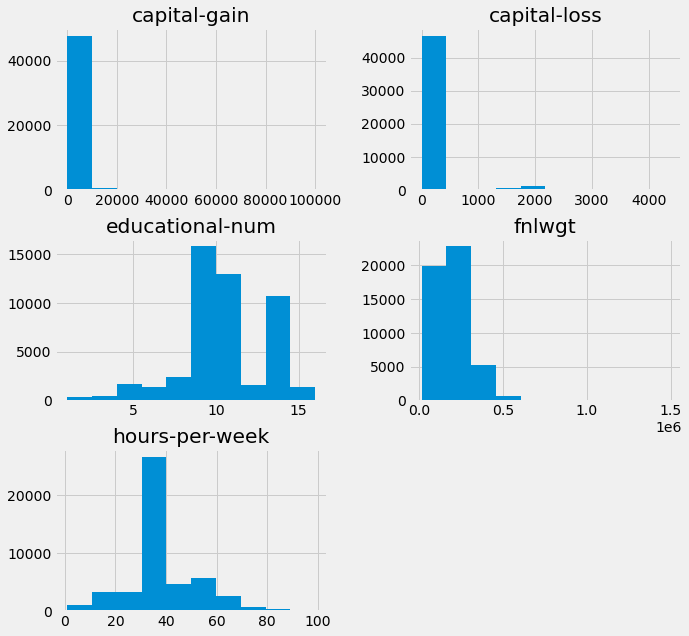

In [7]:
# fig, axes = plt.subplots(1, 6)
# for i in range(6):
#     df[features[i+1]].hist(ax=axes[0,i])
df[features[1:]].hist(figsize=(10,10))
plt.show()

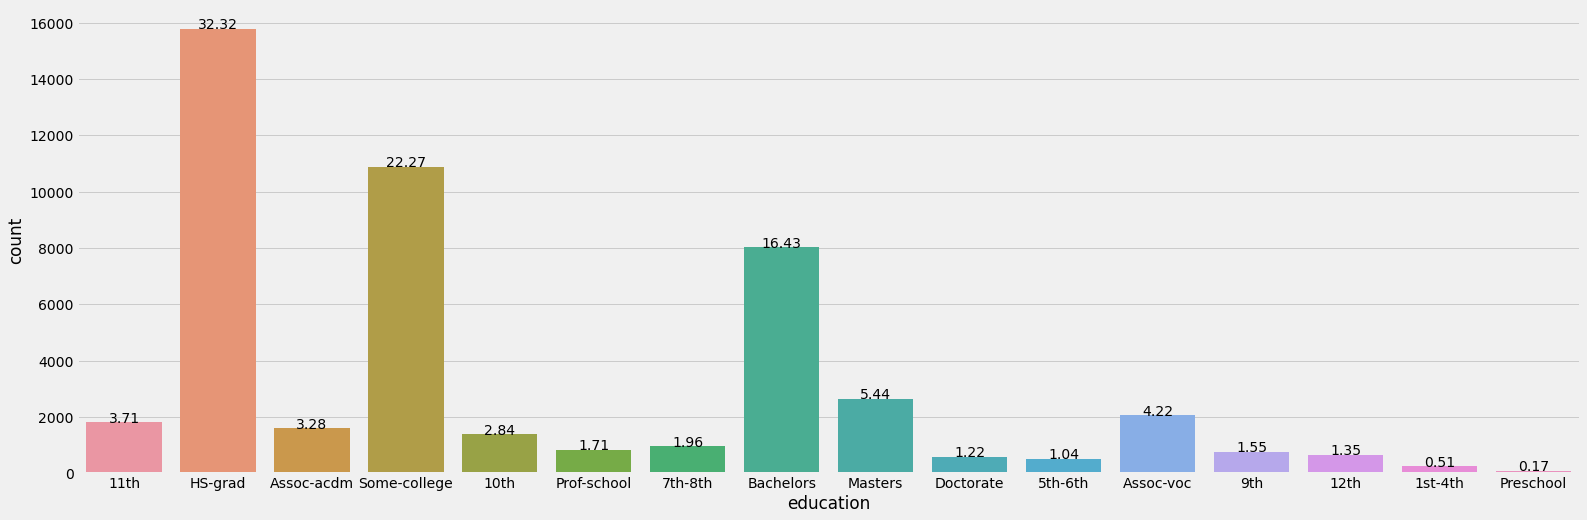

In [8]:
import seaborn as sns

plt.figure(figsize=(24,8))
total = float(len(df["income"]) )

ax = sns.countplot(x="education", data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
plt.show()

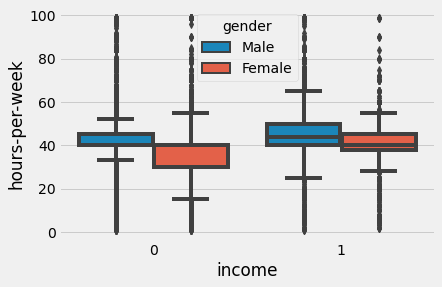

In [9]:
sns.boxplot(x='income',y ='hours-per-week', hue='gender',data=df)
plt.show()

<AxesSubplot:>

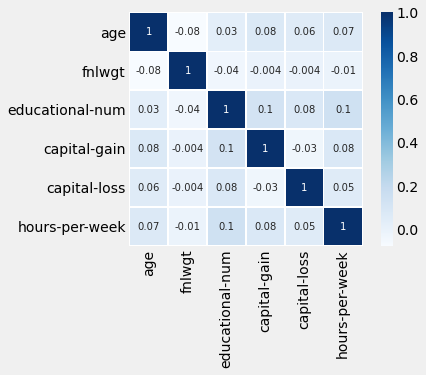

In [10]:
corr = df[features].corr()
sns.heatmap(corr, cmap='Blues', 
            annot=True, annot_kws={"size":10}, fmt='.1g', 
            square=True, linewidths=.5)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = df[features], df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

logit = LogisticRegression()
logit.fit(X_train, y_train)
logit.score(X_test, y_test)

0.7985464223564336

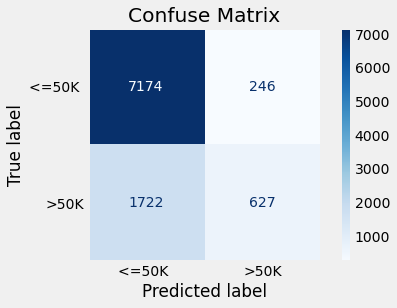

In [12]:
from sklearn.metrics import plot_confusion_matrix

# 類別標籤
class_names = ['<=50K ', '>50K']
disp = plot_confusion_matrix(logit, X_test, y_test, 
                             display_labels=class_names, 
                             cmap=plt.cm.Blues)
disp.ax_.set_title('Confuse Matrix')
plt.grid()

In [13]:
from sklearn.metrics import classification_report
# 產生分類報告
y_pred = logit.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      7420
           1       0.72      0.27      0.39      2349

    accuracy                           0.80      9769
   macro avg       0.76      0.62      0.63      9769
weighted avg       0.79      0.80      0.76      9769



In [14]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler().fit(X_train)
X_train_std = scalar.transform(X_train)
X_test_std = scalar.transform(X_test)

# 預設從 1e-4 ~ 1e4 間產生 10 個 C 值進行交叉驗證
clf = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', n_jobs=-1)
clf.fit(X_train_std, y_train)
print('最佳 C 值：', clf.C_)
y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

最佳 C 值： [21.5443469]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7420
           1       0.69      0.39      0.50      2349

    accuracy                           0.81      9769
   macro avg       0.76      0.67      0.69      9769
weighted avg       0.80      0.81      0.79      9769



In [15]:
# 預設從 1e-4 ~ 1e4 間產生 30 個 C 值進行交叉驗證
clf = LogisticRegressionCV(Cs=30, cv=5, penalty='l1', solver='saga', n_jobs=-1)
clf.fit(X_train_std, y_train)
print('最佳 C 值：', clf.C_)
y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

最佳 C 值： [0.72789538]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7420
           1       0.69      0.39      0.50      2349

    accuracy                           0.81      9769
   macro avg       0.76      0.67      0.69      9769
weighted avg       0.80      0.81      0.79      9769



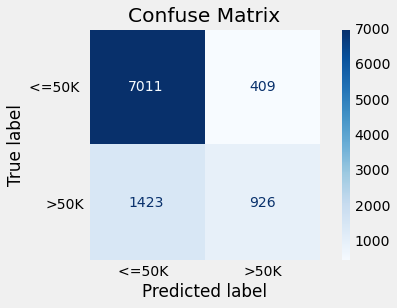

In [16]:
disp = plot_confusion_matrix(clf, X_test_std, y_test, 
                             display_labels=class_names, 
                             cmap=plt.cm.Blues)
disp.ax_.set_title('Confuse Matrix')
plt.grid()